Lambda School Data Science

*Unit 4, Sprint 1, Module 2*

---

# Vector Representations (Prepare)


As we learned yesterday, machines cannot interpret raw text. We need to transform that text into something we/machines can more readily analyze. Yesterday, we did simple counts of counts to summarize the content of Amazon reviews. Today, we'll extend those concepts to talk about vector representations such as Bag of Words (BoW) and word embedding models. We'll use those representations for search, visualization, and prepare for our classification day tomorrow. 

Processing text data to prepare it for machine learning models often means translating the information from documents into a numerical format. Bag-of-Words approaches (sometimes referred to as Frequency-Based word embeddings) accomplish this by "vectorizing" tokenized documents. This is done by representing each document as a row in a DataFrame and creating a column for each unique word in the corpora (group of documents). The presence or lack of a given word in a document is then represented either as a raw count of how many times a given word appears in a document (CountVectorizer) or as that word's TF-IDF score (TfidfVectorizer).

On the python side, we will be focusing on `sklearn` and `spacy` today.  

## Case Study

We're going to pretend we're on the datascience team at the BBC. We want to recommend articles to visitors to on the BBC website based on the article they just read. Our team wants 

**Dataset:**

[D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.](http://mlg.ucd.ie/datasets/bbc.html)
*Please note that the dataset has been sampled down to tech articles only.* 

## Learning Objectives
* <a href="#p1">Part 1</a>: Represent a document as a vector
* <a href="#p2">Part 2</a>: Query Documents by Similarity
* <a href="#p3">Part 3</a>: Apply word embedding models to create document vectors

### Let's start with an analogy

![](https://peterbeshai.com/static/d9c3868cc1becd7648da453597a5d616/36dbb/DER_cube.jpg)

Pretend that the objecting floating in the room is our raw text dataset (i.e. a collection of documents). 

A vectorizer is a mathamatical transformation that takes our raw text data and transforms it into a numerical representation (i.e. numbers inside of vectors). 

Depending on which vectorizer you use, you will be capturing some of the information encoded in the text but not other information. 

So, as the analogy goes, depending which side of the floating object you stand and shine a light from, you will only see a portion of the information that exists in your text data set. Apply one vectorizer and you'll get word counts but not the contextual meaning; apply another vectorizer and you'll get the contextual meaning of the words but not the counts. 

**Take Away:** Understand the benefits and limitations of using each of the vectorizers that we'll be learning today. 

----

# Represent a document as a vector (Learn)
<a id="p1"></a>

## Overview

In this section, we are going to create Document Term Matrices (DTM). Each column represents a word. Each row represents a document. The value in each cell can be range of different things. The most traditional: counts of appearances of words, does the word appear at all (binary), and term-frequency inverse-document frequency (TF-IDF). 

**Discussion:** Don't we loose all the context and grammar if we do this? So Why does it work?

## Follow Along

In [1]:
""" Import Statements """

# Classics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import spacy
nlp = spacy.load("en_core_web_lg")

In [2]:
# alternative way to load in spaCy language model
import en_core_web_lg
nlp = en_core_web_lg.load()

**Warm Up (_3 Minutes_)**

Extract the tokens from this sentence using Spacy. Text is from [OpenAI](https://openai.com/blog/better-language-models/)

In [3]:
text = """GPT-2 displays a broad set of capabilities, including the ability to generate conditional synthetic text samples of unprecedented quality, where we prime the model with an input and have it generate a lengthy continuation. In addition, GPT-2 outperforms other language models trained on specific domains (like Wikipedia, news, or books) without needing to use these domain-specific training datasets. On language tasks like question answering, reading comprehension, summarization, and translation, GPT-2 begins to learn these tasks from the raw text, using no task-specific training data. While scores on these downstream tasks are far from state-of-the-art, they suggest that the tasks can benefit from unsupervised techniques, given sufficient (unlabeled) data and compute."""

In [4]:
text

'GPT-2 displays a broad set of capabilities, including the ability to generate conditional synthetic text samples of unprecedented quality, where we prime the model with an input and have it generate a lengthy continuation. In addition, GPT-2 outperforms other language models trained on specific domains (like Wikipedia, news, or books) without needing to use these domain-specific training datasets. On language tasks like question answering, reading comprehension, summarization, and translation, GPT-2 begins to learn these tasks from the raw text, using no task-specific training data. While scores on these downstream tasks are far from state-of-the-art, they suggest that the tasks can benefit from unsupervised techniques, given sufficient (unlabeled) data and compute.'

In [7]:
# use doc to create a list of lemmas
def create_lemmas(text):
    """
    This function takes in a text document and returns a list of lemmas
    """
    
    # our language model creates tokens for us and flags their attributes
    doc = nlp(text)
    
    lemmas = []

    for token in doc:
        # apply token attribute filters
        if (token.is_punct == False) & (token.is_stop == False):
            # use the dot operator to access the lower case lemma of the token
            lemmas.append(token.lemma_.lower())

    return lemmas

In [8]:
create_lemmas(text)

['gpt-2',
 'display',
 'broad',
 'set',
 'capability',
 'include',
 'ability',
 'generate',
 'conditional',
 'synthetic',
 'text',
 'sample',
 'unprecedented',
 'quality',
 'prime',
 'model',
 'input',
 'generate',
 'lengthy',
 'continuation',
 'addition',
 'gpt-2',
 'outperform',
 'language',
 'model',
 'train',
 'specific',
 'domain',
 'like',
 'wikipedia',
 'news',
 'book',
 'need',
 'use',
 'domain',
 'specific',
 'training',
 'dataset',
 'language',
 'task',
 'like',
 'question',
 'answer',
 'read',
 'comprehension',
 'summarization',
 'translation',
 'gpt-2',
 'begin',
 'learn',
 'task',
 'raw',
 'text',
 'task',
 'specific',
 'training',
 'datum',
 'score',
 'downstream',
 'task',
 'far',
 'state',
 'art',
 'suggest',
 'task',
 'benefit',
 'unsupervised',
 'technique',
 'give',
 'sufficient',
 'unlabeled',
 'datum',
 'compute']

In [10]:
import os 

def gather_data(filefolder):
    """ Produces List of Documents from a Directory
    
    filefolder (str): a path of .txt files
    
    returns list of strings 
    """
    
    data = []
    
    files = os.listdir(filefolder) # Causes variation across machines
    
    for article in files: 
        
        path = os.path.join(filefolder, article)
                    
        if  path[-3:] == 'txt': # os ~endswith('txt')
            with open(path, 'rb') as f:
                data.append(f.read())
    
    return data

In [11]:
data = gather_data('./data')

In [12]:
len(data)

401

In [14]:
# we have articles taken from a BBC website
data[10]

b'Speak easy plan for media players\n\nMusic and film fans will be able to control their digital media players just by speaking to them, under plans in development by two US firms.\n\nScanSoft and Gracenote are developing technology to give people access to their film and music libraries simply by voice control. They want to give people hands-free access to digital music and films in the car, or at home or on the move. Huge media libraries on some players can make finding single songs hard. "Voice command-and-control unlocks the potential of devices that can store large digital music collections," said Ross Blanchard, vice president of business development for Gracenote. "These applications will radically change the car entertainment experience, allowing drivers to enjoy their entire music collections without ever taking their hands off the steering wheel," he added.\n\nGracenote provides music library information for millions of different albums for jukeboxes such as Apple\'s iTunes. 

-----
# CountVectorizer

![](https://images4.programmersought.com/947/0a/0acb9279d17a1631bcfb154583cca443.JPEG)

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

# list of text documents
text = ["We created a new dataset which emphasizes diversity of content, by scraping content from the Internet.",
        "In order to preserve document quality, we used only pages which have been curated/filtered by humans—specifically, we used outbound links from Reddit which received at least 3 karma.",
        "This can be thought of as a heuristic indicator for whether other users found the link interesting (whether educational or funny), leading to higher data quality than other similar datasets, such as CommonCrawl."]

# create the transformer
vect = CountVectorizer(ngram_range=(1,2))

# build vocab
vect.fit(text)

# transform text
dtm = vect.transform(text)

In [32]:
# output is stored in a compressed form
dtm

<3x133 sparse matrix of type '<class 'numpy.int64'>'
	with 141 stored elements in Compressed Sparse Row format>

In [33]:
dtm.toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        0],
       [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 1,
        1],
       [2, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 

In [34]:
dtm = pd.DataFrame(data=dtm.toarray(), columns=vect.get_feature_names())

In [35]:
dtm

,as,as commoncrawl,as heuristic,at,at least,be,be thought,been,been curated,by,...,we,we created,we used,whether,whether educational,whether other,which,which emphasizes,which have,which received
0,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,1,1,0,0
1,0,0,0,1,1,0,0,1,1,1,...,2,0,2,0,0,0,2,0,1,1
2,2,1,1,0,0,1,1,0,0,0,...,0,0,0,2,1,1,0,0,0,0


In [37]:
# 
dtm.sum().sort_values(ascending=False)

which             3
we                3
as                2
by                2
other             2
                 ..
found             1
for whether       1
for               1
filtered by       1
which received    1
Length: 133, dtype: int64

In [38]:
# a doc vector
dtm.iloc[0]

as                  0
as commoncrawl      0
as heuristic        0
at                  0
at least            0
                   ..
whether other       0
which               1
which emphasizes    1
which have          0
which received      0
Name: 0, Length: 133, dtype: int64

**Three Minute Challenge:** 
* Apply CountVectorizer to our BBC Data
* Store results in a dataframe called `dtm`
* Extra Challenge - Try to Customize CountVectorizer with Spacy Processing

In [41]:
# Apply CountVectorizer to our Data
# Use custom Spacy Vectorizer
# BBC articles in `data` variable

from sklearn.feature_extraction.text import CountVectorizer

# instantiate bag of words vectorizer
vect = CountVectorizer(tokenizer=create_lemmas)

#Learn our Vocab
vect.fit(data)

# Get sparse dtm (i.e. transform the data)
dtm = vect.transform(data)

# move the sparse dtm into a dense pandas dataframe
dtm = pd.DataFrame(data=dtm.toarray(), columns=vect.get_feature_names())

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [42]:
dtm

,\n,\n\n,\n\n\n\n,\n\n\n\n\n\n,\n\n\n,\n\n,\n\n \n\n,\n,\n \n\n,\n \n\n\n,...,zero,zhang,zip,zodiac,zombie,zone,zonealarm,zoom,zurich,£
0,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
397,1,4,0,0,1,0,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
398,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
399,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# TfidfVectorizer

## Term Frequency - Inverse Document Frequency (TF-IDF)

![](https://miro.medium.com/max/1404/1*mu6G-cBmWlENS4pWHEnGcg@2x.jpeg)


**Term Frequency:** Percentage of words in document for each word

**Document Frequency:** A penalty for the word existing in a high number of documents.

**MAIN IDEA:**
The purpose of TF-IDF is to find what is **unique** to each document. Because of this we will penalize the term frequencies of words that are common across all documents which will allow for each document's most different topics to rise to the top.


IDF is a penalization.

![](https://upload.wikimedia.org/wikipedia/commons/8/81/Logarithm_plots.png)

It's useful to reference both the algebraic and geometric representations of a single mathematical ideal whenever possible in order to build the fullest understanding possible. 

The IDf portion of the TF-IDF equation has been coded up below so that we can play around with the values and get a better understanding of how this portion of the equation works. 

NOTE: There are many different ways that one could choose to construct the equation for the IDF term, don't let that trip you up; different constructions of the equation serve different purposes and which you ultimately use simply depends on your problem/task. You can [check out a few different ways to build that IDF term here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In practice, you usually don't even have to think about the mathematical formulation of the IDF term. You simply import the tfidf vectorizer and use it's api. The rare exception to this would if you are working a very particular kind of problem where the open source implementation of tfidf doesn't suit your needs and so then you might consider creating your own equation or using a different one that you read about. 

In [43]:
# inverse document frequency score 
# the plus ones are constants that shift the around the baseline value 
def idf(n, df):
    """
    Parameters
    ----------
    n: int
        num of docs in corpus (i.e. corpus means a collection of documents)
        
    df: int
        num of docs that term t (i.e. a token) appears in 

    Returns
    -------
    inverse docuemnt frequency: float
    """

    return np.log(n / df)

In [79]:
n = 100 # num of docs in corpus
df_range = 100
IDF = []

# calculate a IDF score for a range of df values
for df in range(1, df_range+1):
    idf_score = idf(n, df)
    IDF.append(idf_score)

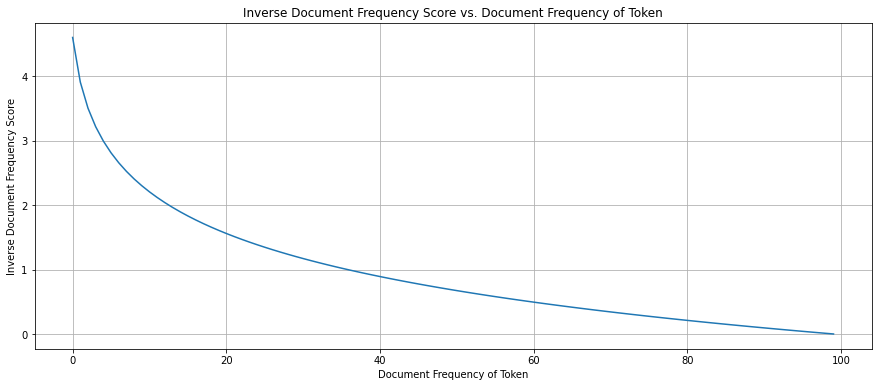

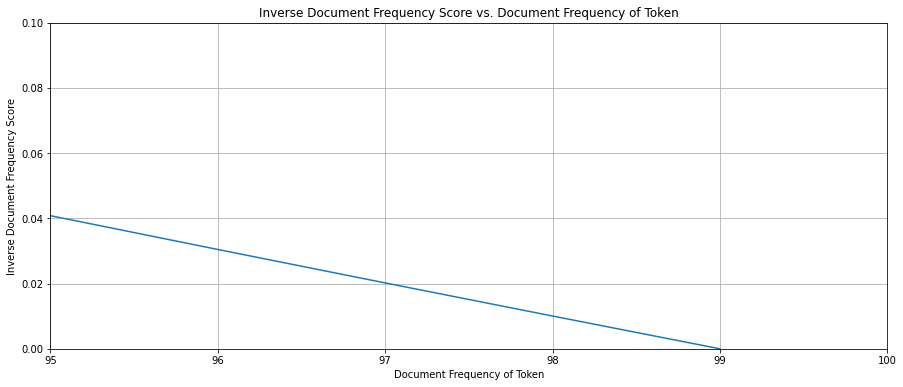

In [80]:
plt.figure(figsize=(15,6))
plt.title("Inverse Document Frequency Score vs. Document Frequency of Token")
plt.ylabel("Inverse Document Frequency Score")
plt.xlabel("Document Frequency of Token")
plt.grid()
plt.plot(IDF);
plt.show()

plt.figure(figsize=(15,6))
plt.title("Inverse Document Frequency Score vs. Document Frequency of Token")
plt.ylabel("Inverse Document Frequency Score")
plt.xlabel("Document Frequency of Token")
plt.xlim(95,100)
plt.ylim(0,0.10)
plt.grid()
plt.plot(IDF);
plt.show()

In [45]:
# let's work through a couple of examples to help build intuition 

n = 100 # num of docs in corpus

# imagine the token we are considering is "purchase" and it rare appears

tf = 3
df = 10

tfdif_score = tf * idf(n, df)
print("tfdif score for word 'purchase':", tfdif_score)

# imagine the token that we are considering is "the" and it appears often

tf = 50
df = 95

tfdif_score = tf * idf(n, df)
print("tfdif score for word 'the':", tfdif_score)

tfdif score for word 'purchase': 6.907755278982138
tfdif score for word 'the': 2.5646647193775243


tfdif score "rewards" words that don't appear in many documents, b/c it means the word is more important in the few docs it does appear in.

Now that we have built some intuition on how tfidf works, let's use sklearn's implementations to vectorizer our dataset. 

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer()

# Create a vocabulary and get word counts per document
tfidf.fit(data)

# Similiar to fit_predict
dtm = tfidf.transform(data)

In [87]:
dtm

<401x12098 sparse matrix of type '<class 'numpy.float64'>'
	with 99669 stored elements in Compressed Sparse Row format>

In [88]:
# View Feature Matrix as DataFrame
dtm = pd.DataFrame(data=dtm.toarray(), columns=tfidf.get_feature_names())

In [89]:
dtm

,00,000,000s,0051,007,01,028,04m,05,0530,...,zip,zodiac,zombie,zombies,zone,zonealarm,zones,zoom,zooms,zurich
0,0.0,0.022722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.051515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
def tokenize(document):
    """
    Takes a doc and returns a list of tokens in the form of lemmas.
    Stop words and punctuation are filtered out. 
    """
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [91]:
# Tunning Parameters

# Instantiate vectorizer object
tfidf = TfidfVectorizer(tokenizer = tokenize)

# Create a vocabulary and get word counts per document
tfidf.fit(data)

# Similiar to fit_predict
dtm = tfidf.transform(data)

# View Feature Matrix as DataFrame
dtm = pd.DataFrame(data=dtm.toarray(), columns=tfidf.get_feature_names())

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [92]:
dtm

,,$,'em,+,-top,.22,.aero,.biz,.com,.fr,...,zero,zhang,zip,zodiac,zombie,zone,zonealarm,zoom,zurich,£
0,0.063287,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030784
1,0.095902,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.082253,0.050228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044455
3,0.055215,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.050556,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0.048175,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
397,0.072020,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
398,0.069910,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034006
399,0.056241,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


## Challenge

During this module's project assignment, you will transform data science job listings to vector representations for analysis downstream. 

# Query Documents by Similarity (Learn)
<a id="p2"></a>

## Overview

Have you ever considered how a search bar works? You may just think that search bars simply match your input text againist the documents. While there are many different mechanisms for the 'match', one of the most classic is to search by similarity. We will apply n-dimensional distance to measure similarity, and query for input and output. 

## Follow Along

### Cosine Similarity (Brute Force)

In [93]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate Distance of TF-IDF Vectors
dist_matrix = cosine_similarity(dtm)

# Turn it into a DataFrame
df_sim = pd.DataFrame(data=dist_matrix)

In [94]:
# Our Similarity Matrix is ? size 
df_sim.shape

(401, 401)

In [95]:
# Each row is the similarity of one document to all other documents (including itself)
df_sim.iloc[:10, :10]

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.084002,0.041227,0.012488,0.062371,0.017335,0.039736,0.052995,0.024812,0.065189
1,0.084002,1.000000,0.056826,0.014399,0.083363,0.049264,0.025702,0.030090,0.018078,0.151516
2,0.041227,0.056826,1.000000,0.013972,0.053996,0.040081,0.119963,0.211743,0.067121,0.048864
3,0.012488,0.014399,0.013972,1.000000,0.025195,0.024424,0.019712,0.025402,0.039259,0.188520
4,0.062371,0.083363,0.053996,0.025195,1.000000,0.025933,0.043906,0.056447,0.014877,0.178562
5,0.017335,0.049264,0.040081,0.024424,0.025933,1.000000,0.032453,0.020929,0.016596,0.036649
6,0.039736,0.025702,0.119963,0.019712,0.043906,0.032453,1.000000,0.107335,0.038974,0.031836
7,0.052995,0.030090,0.211743,0.025402,0.056447,0.020929,0.107335,1.000000,0.057831,0.054703
8,0.024812,0.018078,0.067121,0.039259,0.014877,0.016596,0.038974,0.057831,1.000000,0.043838
9,0.065189,0.151516,0.048864,0.188520,0.178562,0.036649,0.031836,0.054703,0.043838,1.000000


In [96]:
# Grab the row and pick off the indicies of the most/least similar docs
doc_that_user_is_reading_index = 0
sim_scores_for_doc_user_is_reading = df_sim[doc_that_user_is_reading_index].sort_values(ascending=False)

In [97]:
sim_scores_for_doc_user_is_reading.head()

0      1.000000
62     1.000000
297    0.365110
300    0.353708
92     0.332187
Name: 0, dtype: float64

In [98]:
doc_that_user_is_reading = data[0]
doc_that_user_is_rec = data[297]

In [99]:
doc_that_user_is_reading

b'Mobiles rack up 20 years of use\n\nMobile phones in the UK are celebrating their 20th anniversary this weekend.\n\nBritain\'s first mobile phone call was made across the Vodafone network on 1 January 1985 by veteran comedian Ernie Wise. In the 20 years since that day, mobile phones have become an integral part of modern life and now almost 90% of Britons own a handset. Mobiles have become so popular that many people use their handset as their only phone and rarely use a landline.\n\nThe first ever call over a portable phone was made in 1973 in New York but it took 10 years for the first commercial mobile service to be launched. The UK was not far behind the rest of the world in setting up networks in 1985 that let people make calls while they walked. The first call was made from St Katherine\'s dock to Vodafone\'s head office in Newbury which at the time was over a curry house. For the first nine days of 1985 Vodafone was the only firm with a mobile network in the UK. Then on 10 Janu

In [100]:
doc_that_user_is_rec

b'\'Friends fear\' with lost mobiles\n\nPeople are becoming so dependent on their mobile phones that one in three are concerned that losing their phone would mean they lose their friends.\n\nMore than 50% of mobile owners reported they had had their phone stolen or lost in the last three years. More than half (54%) of those asked in a poll for mobile firm Intervoice said that they do not have another address book. A fifth rely entirely on mobiles. About 80% of UK adults own at least one mobile, according to official figures. It is estimated that 53% of over 65s own a mobile, according to Intervoice, but the figures are higher for those aged between 15 and 34.\n\nMost 15 to 24-year-olds (94%), and 25 to 34-year-olds (92%), own at least one. Nineteen percent of mobile owners were more concerned about how long it would take to find their contacts\' information again if the phone was lost, stolen or replaced.\n\nThe survey showed that extent to which people have become reliant on their pho

### Wrap our recommendation algorithm in a function

In [101]:
def recommend_similar_article(corpus, doc_term_matrix, user_doc_index):
    """
    """
    
    # Calculate distance of doc vectors
    dist_matrix = cosine_similarity(doc_term_matrix)
    
    # Turn it into a DataFrame
    df_sim = pd.DataFrame(data=dist_matrix)
    
    # sim scores for doc that user is reading
    df_user_doc_sim_scores = df_sim[user_doc_index]
    
    # remove scores of 1.0 so that we don't recommend the article the user's already reading
    df_user_doc_sim_scores = df_user_doc_sim_scores[df_user_doc_sim_scores < 1.0]
    
    # grab the row and pick off the indices of the most/lease similar docs
    sim_scores_for_doc_that_user_is_reading = df_user_doc_sim_scores.sort_values(ascending=False)
    
    # since scores are ranked, index for first article index which will be the most similar
    most_sim_article_index = sim_scores_for_doc_that_user_is_reading.index[0]
    
    doc_that_user_is_rec = corpus[most_sim_article_index]
    
    return doc_that_user_is_rec

In [102]:
user_doc_index = 0
rec_article = recommend_similar_article(data, dtm, user_doc_index)

In [103]:
rec_article

b'\'Friends fear\' with lost mobiles\n\nPeople are becoming so dependent on their mobile phones that one in three are concerned that losing their phone would mean they lose their friends.\n\nMore than 50% of mobile owners reported they had had their phone stolen or lost in the last three years. More than half (54%) of those asked in a poll for mobile firm Intervoice said that they do not have another address book. A fifth rely entirely on mobiles. About 80% of UK adults own at least one mobile, according to official figures. It is estimated that 53% of over 65s own a mobile, according to Intervoice, but the figures are higher for those aged between 15 and 34.\n\nMost 15 to 24-year-olds (94%), and 25 to 34-year-olds (92%), own at least one. Nineteen percent of mobile owners were more concerned about how long it would take to find their contacts\' information again if the phone was lost, stolen or replaced.\n\nThe survey showed that extent to which people have become reliant on their pho

### NearestNeighbor (K-NN) 
![](https://miro.medium.com/max/753/0*jqxx3-dJqFjXD6FA)


Nearest Neighbor models are distance based algorithms. They store your training set in memory. 

When you want to find the nearest neighbors for a point in your test set, then simply calculate the distance of the nearest k points. 

So instead of calculating the every single possible distance between all points (i.e. **Brute Force** ) , NN models only calculate the nearest k distances. 

In [104]:
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors = 5, algorithm='kd_tree')
nn.fit(dtm)

# sample a doc from dtm to use as our query point 
doc_index = 0
doc = [dtm.iloc[doc_index].values]

# Query Using kneighbors 
neigh_dist, neigh_index = nn.kneighbors(doc)

In [105]:
df_sim[doc_that_user_is_reading_index].sort_values(ascending=False)[:5]

0      1.000000
62     1.000000
297    0.365110
300    0.353708
92     0.332187
Name: 0, dtype: float64

In [106]:
neigh_dist

array([[0.        , 0.        , 1.12684521, 1.13691824, 1.15569307]])

In [107]:
neigh_index

array([[  0,  62, 297, 300,  92]])

In [ ]:
rndm_tech_article = [ """
Blockchain technology encompasses so much more than just cryptocurrencies these days. And while these currencies are by far blockchain’s most famous use case, the potential for blockchain far, far exceeds a straightforward transfer of value.
The gaming industry, for example, has always been fairly controversial due to a range of issues. Many players feel particularly worried about the protection of their data, fraudulent activities, high fees, and most of all, unfair and hidden odds.
In these cases, P2P doesn’t just mean peer-to-peer; it means player-to-player. As with the other P2P industries that blockchain is disrupting, such as FinTech, there are already plenty of ways in which blockchain technology is being applied to resolve these issues and many more of the challenges faced by the gaming industry. Here are just a few.
Reducing fraud
The gaming industry suffers a lot from online fraud. One of the main advantages of blockchain technology is that it enables highly secure data encryption. What’s more, all of it is entirely accessible and transparent to the player. In other words, blockchain is a for game changer for venues such as online casinos, lotteries, and virtually anything which relies on random number generation.
On top of this, hackers will have particularly hard time, if it is even possible, to destroy a decentralized blockchain network, making sure gamer data stays safe. This is an inherent feature of distributed ledger technology whereby nodes in the ledger maintain the distributed databases in a shared manner, and each node has the complete information in the entire database.
"""]

# Fit NN for similarity of random doc to BBC dataset

# Query Using kneighbors 

# Inspect Most relevant result

## Challenge

In the module project assignment, you will apply one of these search techniques to retrieve documents related to a query document. 

# Apply word embedding models to create document vectors (Learn)
<a id="p3"></a>

## Overview
### BoW discards textual context

One of the limitations of Bag-of-Words approaches is that any information about the textual context surrounding that word is lost. This also means that with bag-of-words approaches often the only tools that we have for identifying words with similar usage or meaning and subsequently consolidating them into a single vector is through the processes of stemming and lemmatization which tend to be quite limited at consolidating words unless the two words are very close in their spelling or in their root parts-of-speech.

### Embedding approaches preserve more textual context
Word2Vec is an increasingly popular word embedding technique. Like Bag-of-words it learns a real-value vector representation for a predefined fixed-size vocabulary that is generated from a corpus of text. However, in contrast to BoW, Word2Vec approaches are much more capable of accounting for textual context, and are better at discovering words with similar meanings or usages (semantic or syntactic similarity).

### Word2Vec Intuition
### The Distribution Hypothesis

In order to understand how Word2Vec preserves textual context we have to understand what's called the Distribution Hypothesis (Reference: Distribution Hypothesis Theory  -https://en.wikipedia.org/wiki/Distributional_semantics. The Distribution Hypothesis operates under the assumption that words that have similar contexts will have similar meanings. Practically speaking, this means that if two words are found to have similar words both to the right and to the left of them throughout the corpora then those words have the same context and are assumed to have the same meaning. 

> "You shall know a word by the company it keeps" - John Firth

This means that we let the usage of a word define its meaning and its "similarity" to other words. In the following example, which words would you say have a similar meaning? 

**Sentence 1**: Traffic was light today

**Sentence 2**: Traffic was heavy yesterday

**Sentence 3**: Prediction is that traffic will be smooth-flowing tomorrow since it is a national holiday

What words in the above sentences seem to have a similar meaning if all you knew about them was the context in which they appeared above? 

Lets take a look at how this might work in action, the following example is simplified, but will give you an idea of the intuition for how this works.

#### Corpora:

1) "It was the sunniest of days."

2) "It was the raniest of days."

#### Vocabulary:

{"it": 1, "was": 2, "the": 3, "of": 4, "days": 5, "sunniest": 6, "raniest": 7}

### Vectorization

|       doc   | START_was | it_the | was_sunniest | the_of | sunniest_days | of_it | days_was | it_the | was_raniest | raniest_days | of_END |
|----------|-----------|--------|--------------|--------|---------------|-------|----------|--------|-------------|--------------|--------|
| it       | 1         | 0      | 0            | 0      | 0             | 0     | 1        | 0      | 0           | 0            | 0      |
| was      | 0         | 1      | 0            | 0      | 0             | 0     | 0        | 1      | 0           | 0            | 0      |
| the      | 0         | 0      | 1            | 0      | 0             | 0     | 0        | 0      | 1           | 0            | 0      |
| sunniest | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0      | 0           | 0            | 0      |
| of       | 0         | 0      | 0            | 0      | 1             | 0     | 0        | 0      | 0           | 1            | 0      |
| days     | 0         | 0      | 0            | 0      | 0             | 0     | 0        | 0      | 0           | 0            | 1      |
| raniest  | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0      | 0           | 0            | 0      |

Each column vector represents the word's context -in this case defined by the words to the left and right of the center word. How far we look to the left and right of a given word is referred to as our "window of context." Each row vector represents the the different usages of a given word. Word2Vec can consider a larger context than only words that are immediately to the left and right of a given word, but we're going to keep our window of context small for this example. What's most important is that this vectorization has translated our documents from a text representation to a numeric one in a way that preserves information about the underlying context. 

We can see that words that have a similar context will have similar row-vector representations, but before looking that more in-depth, lets simplify our vectorization slightly. You'll notice that we're repeating the column-vector "it_the" twice. Lets combine those into a single vector by adding them element-wise. 

|       *   | START_was | it_the | was_sunniest | the_of | sunniest_days | of_it | days_was | was_raniest | raniest_days | of_END |
|----------|-----------|--------|--------------|--------|---------------|-------|----------|-------------|--------------|--------|
| it       | 1         | 0      | 0            | 0      | 0             | 0     | 1        | 0           | 0            | 0      |
| was      | 0         | 2      | 0            | 0      | 0             | 0     | 0        | 0           | 0            | 0      |
| the      | 0         | 0      | 1            | 0      | 0             | 0     | 0        | 1           | 0            | 0      |
| sunniest | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0           | 0            | 0      |
| of       | 0         | 0      | 0            | 0      | 1             | 0     | 0        | 0           | 1            | 0      |
| days     | 0         | 0      | 0            | 0      | 0             | 0     | 0        | 0           | 0            | 1      |
| raniest  | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0           | 0            | 0      |

Now, can you spot which words have a similar row-vector representation? Hint: Look for values that are repeated in a given column. Each column represents the context that word was found in. If there are multiple words that share a context then those words are understood to have a closer meaning with each other than with other words in the text.

Lets look specifically at the words sunniest and raniest. You'll notice that these two words have exactly the same 10-dimensional vector representation. Based on this very small corpora of text we would conclude that these two words have the same meaning because they share the same usage. Is this a good assumption? Well, they are both referring to the weather outside so that's better than nothing. You could imagine that as our corpora grows larger we will be exposed a greater number of contexts and the Distribution Hypothesis assumption will improve. 

### Word2Vec Variants

#### Skip-Gram

The Skip-Gram method predicts the neighbors’ of a word given a center word. In the skip-gram model, we take a center word and a window of context (neighbors) words to train the model and then predict context words out to some window size for each center word.

This notion of “context” or “neighboring” words is best described by considering a center word and a window of words around it. 

For example, if we consider the sentence **“The speedy Porsche drove past the elegant Rolls-Royce”** and a window size of 2, we’d have the following pairs for the skip-gram model:

**Text:**
**The**	speedy	Porsche	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (the, speedy), (the, Porsche)

**Text:**
The	**speedy**	Porsche	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (speedy, the), (speedy, Porsche), (speedy, drove)

**Text:**
The	speedy	**Porsche**	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (Porsche, the), (Porsche, speedy), (Porsche, drove), (Porsche, past)

**Text:**
The	speedy	Porsche	**drove**	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (drove, speedy), (drove, Porsche), (drove, past), (drove, the)

The **Skip-gram model** is going to output a probability distribution i.e. the probability of a word appearing in context given a center word and we are going to select the vector representation that maximizes the probability.

With CountVectorizer and TF-IDF the best we could do for context was to look at common bi-grams and tri-grams (n-grams). Well, skip-grams go far beyond that and give our model much stronger contextual information.

![alt text](https://www.dropbox.com/s/c7mwy6dk9k99bgh/Image%202%20-%20SkipGrams.jpg?raw=1)

## Continuous Bag of Words

This model takes thes opposite approach from the skip-gram model in that it tries to predict a center word based on the neighboring words. In the case of the CBOW model, we input the context words within the window (such as “the”, “Proshe”, “drove”) and aim to predict the target or center word “speedy” (the input to the prediction pipeline is reversed as compared to the SkipGram model).

A graphical depiction of the input to output prediction pipeline for both variants of the Word2vec model is attached. The graphical depiction will help crystallize the difference between SkipGrams and Continuous Bag of Words.

![alt text](https://www.dropbox.com/s/k3ddmbtd52wq2li/Image%203%20-%20CBOW%20Model.jpg?raw=1)

## Notable Differences between Word Embedding methods:

1) W2V focuses less document topic-modeling. You'll notice that the vectorizations don't really retain much information about the original document that the information came from. At least not in our examples.

2) W2V can result in really large and complex vectorizations. In fact, you need Deep Neural Networks to train your Word2Vec models from scratch, but we can use helpful pretrained embeddings (thank you Google) to do really cool things!

*^ All that noise....AND Spacy has pretrained a Word2Vec model you can just use? WTF JC?*

Let's take a look at how to do it. 

In [108]:
# Process a text
nlp = spacy.load('en_core_web_lg')

In [109]:
word1 = 'banana'
word2 = 'apple'
word3 = 'table'

In [110]:
w1 = nlp(word1)
w2 = nlp(word2)
w3 = nlp(word3)

In [111]:
w1.similarity(w2)

0.5831844567891399

In [112]:
w1.similarity(w3)

0.22562773991991913

In [115]:
doc1 = nlp("It's a warm summer day at the park")
doc2 = nlp("I saw a dog today at the park.")
doc3 = nlp("I hate the void.")

# we can calculate the similarity between docs now! 
doc1.similarity(doc2)

0.8854426864247015

In [116]:
doc1.similarity(doc3)

0.6689585990052233

In [119]:
# import the PCA module from sklearn
from sklearn.decomposition import PCA

def get_word_vectors(words):
    # converts a list of words into their word vectors
    return [nlp(word).vector for word in words]

words = ['machine learning', 
         'artificial intelligence', 
         'data', 'science', 
         'concrete', 'wood', 
         'marble', 'design',
         'color', 'font',
         'suv', 'car', 'truck',
         'cat', 'tiger', 'lion',
         'happy', 'sad', 'love', 'hate']


# intialise pca model and tell it to project data down onto 2 dimensions
pca = PCA(n_components = 2)

# fit the pca model to our 300D data, this will work out which is the best 
# way to project the data down that will best maintain the relative distances 
# between data points. It will store these intructioons on how to transform the data.
pca.fit(get_word_vectors(words))

# Tell our (fitted) pca model to transform our 300D data down onto 2D using the 
# instructions it learnt during the fit phase.
word_vecs_2d = pca.transform(get_word_vectors(words))

# let's look at our new 2D word vectors
word_vecs_2d

array([[-1.02855858,  0.48649742],
       [-1.35987155,  0.95398301],
       [-1.21833053,  1.51802071],
       [-2.34211207,  0.44490612],
       [ 0.50436598,  3.29143923],
       [ 0.62396484,  3.08072981],
       [-0.03407675,  3.85532484],
       [-0.6575883 ,  2.39291911],
       [-1.08078616,  1.38480853],
       [-1.25978302,  0.68138016],
       [ 4.9473031 , -0.93172605],
       [ 4.47895183, -0.73441458],
       [ 4.51181787, -0.70971111],
       [ 0.21485104, -2.17666392],
       [ 0.06027872, -1.38398071],
       [-0.10706903, -1.54171174],
       [-1.20903603, -2.39436948],
       [-1.59915725, -3.05936855],
       [-1.75254083, -2.26806634],
       [-1.69262327, -2.88999646]])

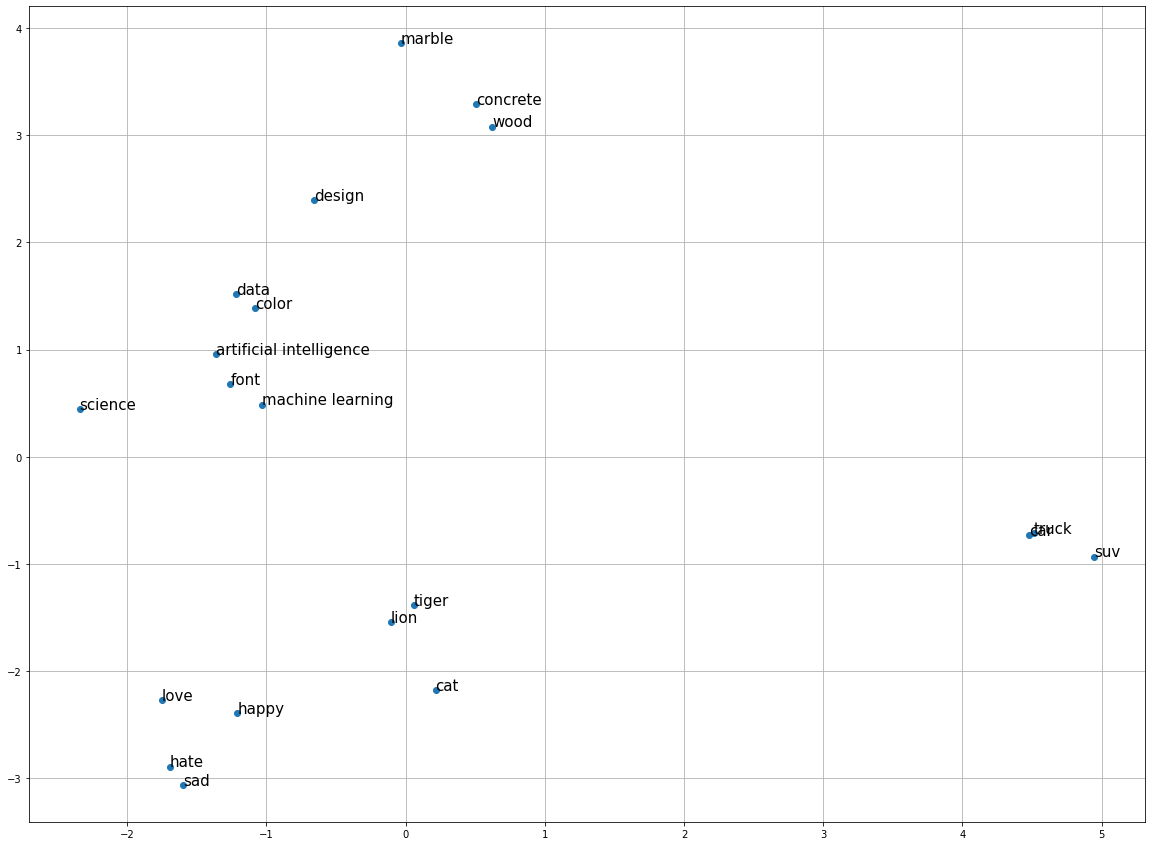

In [120]:
# create a nice big plot 
plt.figure(figsize=(20,15))

# plot the scatter plot of where the words will be
plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1])

# for each word and coordinate pair: draw the text on the plot
for word, coord in zip(words, word_vecs_2d):
    x, y = coord
    plt.text(x, y, word, size= 15)

# show the plot
plt.grid();
plt.show()

## Challenge

You will extract word embeddings from documents using Spacy's pre-trained model in the upcoming module project. 

## Man + Woman - King = Queen 

Check out [**this article**](https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/) which explores the above equation

# Sources

* Spacy 101 - https://course.spacy.io
* NLTK Book - https://www.nltk.org/book/
* An Introduction to Information Retrieval - https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf